<a href="https://colab.research.google.com/github/Olivia-Feldman/NUGAN-DISTGAN/blob/Andrew/NuGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up the environment

In [1]:
import torch
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

# Download the MNIST dataset

[MNIST PyTorch Docs](https://pytorch.org/vision/stable/datasets.html#mnist)

In [2]:
# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

# Showing shape of train and test dataset

In [3]:
print("Train Shape:", train_dataset.data.shape, "Test Shape:", test_dataset.data.shape)

Train Shape: torch.Size([60000, 28, 28]) Test Shape: torch.Size([10000, 28, 28])


# Define a function to initialize the weights of the network


In [4]:
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

In [5]:
def visualize_results(gan):
      sample_z_ = torch.rand((10, gan.z_dim)).cuda()
      samples = gan.G(sample_z_)
      samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
      samples = (samples + 1) / 2
      plt.figure(figsize=((1,10)))
      fig,ax = plt.subplots(1,10)
      for i in range(10):
          s=ax[i].imshow(np.squeeze(samples[i,]))
          s=ax[i].get_xaxis().set_visible(False)
          s=ax[i].get_yaxis().set_visible(False)
      s=plt.show()

In [6]:
from scipy.sparse import linalg

def get_eigenvectors(model, loss, dataloader):
    # Adds up the number of weights in the model
    num_params = sum(p.numel() for p in model.parameters())

    hv = HessianVector(model=model, 
                       dataloader=dataloader, 
                       loss=loss)
    
    A = linalg.LinearOperator((num_params,num_params), matvec=lambda v: hv.calculate(torch.tensor(v).float()))

    print("\tGot eigenvectors", A.shape)
    # Gets 'k' with the Largest (algebraic) eigenvalues
    vals, vecs = linalg.eigsh(A, k=2, mode='LA')

    print("\tEigenvalues are {:.2f} and {:.2f}".format(vals[0],vals[1]))

# Calculates the Eigenvalues of the Discriminator


[linalg.eigsh](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigsh.html)

In [7]:
def get_d_eigenvectors(D, G, loss, dataloader):

    num_params = sum(p.numel() for p in D.parameters())

    hv = HessianVector(model=D, 
                       dataloader=dataloader, 
                       loss=loss)
    
    A = linalg.LinearOperator((num_params,num_params), matvec=lambda v: hv.calculate(torch.tensor(v).float()))

    print("\tGot eigenvectors", A.shape)
    # Gets 'k' with the Largest (algebraic) eigenvalues
    vals, vecs = linalg.eigsh(A, k=2, mode='LA')

    print("\tEigenvalues are {:.2f} and {:.2f}".format(vals[0],vals[1]))

# Hessian Vector Class



*   scipy.sparse.linalg.LinearOperator
  *   [Docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.LinearOperator.html)



In [8]:
class HessianVector():

    def __init__(self, model, dataloader, loss, percentage=0.2):
        self.size = int(sum(param.numel() for param in model.parameters()))
        self.grad_vec = torch.zeros(self.size)
        self.percentage = percentage
        self.dataloader = dataloader
        self.model = model
        self.loss = loss


    def calculate(self, vector):
        full_hessian = None
        # Place vector on the GPU
        vector = vector.cuda()

        grad_vec = None

        batch_grad = self.prepare_grad()

        #print("Batch Shape:", batch_grad.shape)

        self.zero_grad()
        # Take the second gradient
        grad_grad = torch.autograd.grad(batch_grad, self.model.parameters(), grad_outputs=vector, only_inputs=True, retain_graph=True)
        # Concatentate the results over the different components of the network
        hessian_vec_prod = torch.cat([g.contiguous().view(-1) for g in grad_grad])
        # Adds/Sets Full Hessian
        if full_hessian is not None:
            full_hessian += hessian_vec_prod
        else:
            full_hessian = hessian_vec_prod

        # Hessian must be returned on the CPU
        return full_hessian.cpu()

    def zero_grad(self):
        """
        Zeros out the gradient info for each parameters and vectorize
        """

        for p in self.model.parameters():
            if p.grad is not None:
                p.grad.data.zero_()


    def prepare_grad(self):


        grad_vec = None

        grad_dict = torch.autograd.grad(self.loss, self.model.parameters(), create_graph=True, retain_graph=True)
        grad_vec = torch.cat([g.contiguous().view(-1) for g in grad_dict])
        self.grad_vec = grad_vec
        return self.grad_vec


# Generator and Discriminator class definition

In [9]:
class Generator(nn.Module):
    def __init__(self, input_dim=100, output_dim=1, input_size=32, base_size=64):
        super(Generator, self).__init__()  
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = 28
        self.base_size = base_size    


        # self.fc1 = nn.Linear(self.input_dim, self.base_size)
        # self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        # self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        # self.fc4 = nn.Linear(self.fc3.out_features, self.output_dim * self.input_size * self.input_size)

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(2*self.base_size * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(2*self.base_size, self.base_size, 4, 2, 1),
            nn.BatchNorm2d(self.base_size),
            nn.ReLU(),
            nn.ConvTranspose2d(self.base_size, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )

        initialize_weights(self)
    
    # forward method
    def forward(self, x): 

        # x = F.leaky_relu(self.fc1(x), 0.2)
        # x = F.leaky_relu(self.fc2(x), 0.2)
        # x = F.leaky_relu(self.fc3(x), 0.2)
        # x = torch.tanh(self.fc4(x))
        # x = x.view(-1, self.output_dim, self.input_size, self.input_size)
        # return x

        x = self.fc(x)
        x = x.view(-1, 2*self.base_size, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)

        return x
    
class Discriminator(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, input_size=32, base_size=64):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.base_size = base_size

        # self.fc1 = nn.Linear(self.input_size * self.input_size, self.base_size)
        # self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        # self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        # self.fc4 = nn.Linear(self.fc3.out_features, self.output_dim)

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, self.base_size, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.base_size, 2*self.base_size, 4, 2, 1),
            nn.BatchNorm2d(2*self.base_size),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(2*self.base_size * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid(),
        )

        initialize_weights(self)
    
    # forward method
    def forward(self, x):

        # x = x.view(-1, self.input_size * self.input_size)
        # x = F.leaky_relu(self.fc1(x), 0.2)
        # x = F.dropout(x, 0.3)
        # x = F.leaky_relu(self.fc2(x), 0.2)
        # x = F.dropout(x, 0.3)
        # x = F.leaky_relu(self.fc3(x), 0.2)
        # x = F.dropout(x, 0.3)
        # return torch.sigmoid(self.fc4(x))

        x = self.conv(x)
        x = x.view(-1, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)

        return x

# Construction of GAN model

[Modifying gradients in PyTorch](https://discuss.pytorch.org/t/how-to-modify-the-gradient-manually/7483)

In [10]:
class GAN():
    def __init__(self,params):
        # parameters
        self.epoch = params['max_epochs']
        self.sample_num = 100
        self.batch_size = 300
        self.input_size = 28
        self.z_dim = params['z_dim']
        self.base_size = params['base_size']

        # load dataset
        self.data_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=self.batch_size, 
                                               shuffle=True)
        self.test_loader = torch.utils.data.DataLoader(test_dataset, 
                                               batch_size=self.batch_size, 
                                               shuffle=True)
        data = self.data_loader.__iter__().__next__()[0]

        #mnist_dim = data.shape[1] * data.shape[2]

        #print(data.shape)
        #self.data_width = data.shape[2]
        #self.data_height = data.shape[3]

        # initialization of the generator and discriminator
        self.G = Generator(
            input_dim=self.z_dim,       # 16
            output_dim=data.shape[1],   # 1
            input_size=self.input_size, # 28
            base_size=self.base_size    # 64
            ).cuda()

        self.D = Discriminator(
            input_dim=data.shape[1],    
            output_dim=1,
            input_size=self.input_size, 
            base_size=self.base_size
            ).cuda()

        #print("Encoder", data.shape[1], self.input_size, self.base_size)
        #self.E = encoder(input_dim=data.shape[1], output_dim=self.z_dim, input_size=self.input_size, base_size=self.base_size).cuda()
        #self.G_optimizer = optim.SGD(self.G.parameters(), lr=params['lr_g'])
        #self.D_optimizer = optim.SGD(self.D.parameters(), lr=params['lr_d'])
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=params['lr_d'], betas=(params['beta1'], params['beta2']))
        #self.E_optimizer = optim.Adam(self.E.parameters(), lr=1e-2, weight_decay=1e-4)
        
        # initialization of the loss function

        self.BCE_loss = nn.BCELoss().cuda()
        #self.smooth_loss = nn.SmoothL1Loss().cuda()
        
        # Gettng a batch of noise to generate the fake data
        self.sample_z_ = torch.rand((self.batch_size, self.z_dim)).cuda()

        # Function to train the GAN, where you alternate between the training of the genenator and discriminator
#--------------------------------------------------------------------------------------------------------

    def train(self):

       # Setting empty arrays for storing the losses

        Ninner = 1
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []

        # Setting up the labels for real and fake images
        #self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1).cuda(), torch.zeros(self.batch_size, 1).cuda()
        self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1).fill_(0.9).type(torch.float32).cuda(), torch.zeros(self.batch_size, 1).fill_(0.1).type(torch.float32).cuda()
        # print(self.y_real_.shape)
        self.y_real_ = self.y_real_ + (torch.randn(self.y_real_.shape)*0.03).cuda()
        self.y_fake_ = self.y_fake_ + (torch.randn(self.y_fake_.shape)*0.03).cuda()

        print('training start!!')

        randn_var = 0.05
        randn_mean = 0.00

        # Epoch loops

        for epoch in range(self.epoch):
            epoch_start_time = time.time()
            print("Epoch:", epoch+1)

            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                # Generate random noise to push through the generator   

                z_ = torch.rand((self.batch_size, self.z_dim))
                x_, z_ = x_.cuda(), z_.cuda()

                # YOUR CODE HERE
                #--------------------

                # update D network using 
                # 1. Set optimizer gradient to zero
                self.D_optimizer.zero_grad()
                # 2. Set discriminator losses on real and fake data
                x_ = x_ + torch.normal(mean=randn_mean, std=randn_var, size=x_.shape).cuda()
                #x_ = x_ + (torch.randn(x_.shape)*randn_var + randn_mean).cuda() # Adding random noise to input images
                D_real = self.D(x_)
                D_real_loss = self.BCE_loss(D_real, self.y_real_)

                z_ = z_ + torch.normal(mean=randn_mean, std=randn_var, size=z_.shape).cuda()

                G_ = self.G(z_)
                D_fake = self.D(G_)
                D_fake_loss = self.BCE_loss(D_fake, self.y_fake_)
                # 3. Do back propagation to compute gradients
                D_loss = D_real_loss + D_fake_loss

                if (iter == 0) and (((epoch + 1) % 10) == 0):
                    get_eigenvectors(self.D, D_loss, self.data_loader)

                D_loss.backward()

                # if iter == 0:
                #     print("D eigen vectors:")
                #     get_eigenvectors(self.D, self.data_loader, self.BCE_loss)


                # 4. Make a step of D_optimizer
                self.D_optimizer.step()
                # 5. Set the current loss in self.train_hist['D_loss]
                self.train_hist['D_loss'].append(D_loss.item())
                
                # update G network using 
                # 1. Set optimizer gradient to zero
                self.G_optimizer.zero_grad()
                # 2. Set generator losses on fake data
                G_ = self.G(z_)
                D_fake_ = self.D(G_)
                G_loss = self.BCE_loss(D_fake_, self.y_real_)
                if (iter == 0) and (((epoch + 1) % 10) == 0):
                    get_eigenvectors(self.G, G_loss, self.data_loader)
                # 3. Do back propagation to compute gradients
                G_loss.backward()

                # if iter == 0:
                #     print("G eigen vectors:")
                #     get_eigenvectors(self.G, self.data_loader, self.BCE_loss)

                # 4. Make a step of G_optimizer
                self.G_optimizer.step()
                # 5. Set the current loss in self.train_hist['G_loss]    
                self.train_hist['G_loss'].append(G_loss.item())

                # Print iterations and losses
                
                if ((iter + 1) % 50) == 0:
                  print("Epoch: [%2d] [%4d/%4d] D_loss: %.8f, G_loss: %.8f" %
                          ((epoch + 1), (iter + 1), self.data_loader.dataset.__len__() // self.batch_size, D_loss.item(), G_loss.item()))
                
            # Visualize results
            if ((epoch + 1) % 10) == 0:
                with torch.no_grad():
                    visualize_results(self)
                #visualize_gan_optim_loss(self)

        print("Training finished!")

# Training the GAN

training start!!
Epoch: 1
Epoch: [ 1] [  50/ 200] D_loss: 1.30144525, G_loss: 0.86673647
Epoch: [ 1] [ 100/ 200] D_loss: 1.27378774, G_loss: 1.08803821
Epoch: [ 1] [ 150/ 200] D_loss: 1.10381305, G_loss: 1.03722310
Epoch: [ 1] [ 200/ 200] D_loss: 1.07277226, G_loss: 1.37352848
Epoch: 2
Epoch: [ 2] [  50/ 200] D_loss: 1.02451038, G_loss: 1.35779297
Epoch: [ 2] [ 100/ 200] D_loss: 1.04174900, G_loss: 1.22604895
Epoch: [ 2] [ 150/ 200] D_loss: 0.90077770, G_loss: 1.31574941
Epoch: [ 2] [ 200/ 200] D_loss: 1.02602291, G_loss: 1.42858386
Epoch: 3
Epoch: [ 3] [  50/ 200] D_loss: 1.17952633, G_loss: 1.29936111
Epoch: [ 3] [ 100/ 200] D_loss: 1.03397715, G_loss: 1.14715922
Epoch: [ 3] [ 150/ 200] D_loss: 0.83280396, G_loss: 1.32513797
Epoch: [ 3] [ 200/ 200] D_loss: 0.98762059, G_loss: 1.26054716
Epoch: 4
Epoch: [ 4] [  50/ 200] D_loss: 0.90247428, G_loss: 1.32337868
Epoch: [ 4] [ 100/ 200] D_loss: 0.89283186, G_loss: 1.29806280
Epoch: [ 4] [ 150/ 200] D_loss: 0.85827661, G_loss: 1.37142265
Ep

<Figure size 72x720 with 0 Axes>

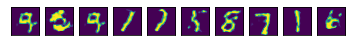

Epoch: 11
Epoch: [11] [  50/ 200] D_loss: 1.02114129, G_loss: 1.30855536
Epoch: [11] [ 100/ 200] D_loss: 1.02753043, G_loss: 1.26080263
Epoch: [11] [ 150/ 200] D_loss: 0.99938756, G_loss: 1.32135069
Epoch: [11] [ 200/ 200] D_loss: 0.97624892, G_loss: 1.22822928
Epoch: 12
Epoch: [12] [  50/ 200] D_loss: 0.98924387, G_loss: 1.27592373
Epoch: [12] [ 100/ 200] D_loss: 0.98661327, G_loss: 1.47168136
Epoch: [12] [ 150/ 200] D_loss: 0.98710883, G_loss: 1.27122986
Epoch: [12] [ 200/ 200] D_loss: 1.07716084, G_loss: 1.32564211
Epoch: 13
Epoch: [13] [  50/ 200] D_loss: 0.99043936, G_loss: 1.20090139
Epoch: [13] [ 100/ 200] D_loss: 1.03091097, G_loss: 1.41239619
Epoch: [13] [ 150/ 200] D_loss: 1.03095388, G_loss: 1.40871894
Epoch: [13] [ 200/ 200] D_loss: 1.01713347, G_loss: 1.28941059
Epoch: 14
Epoch: [14] [  50/ 200] D_loss: 0.93528962, G_loss: 1.20152819
Epoch: [14] [ 100/ 200] D_loss: 0.96683162, G_loss: 1.29902327
Epoch: [14] [ 150/ 200] D_loss: 1.03537083, G_loss: 1.43114638
Epoch: [14] [ 2

<Figure size 72x720 with 0 Axes>

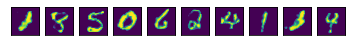

Epoch: 21
Epoch: [21] [  50/ 200] D_loss: 1.06926632, G_loss: 1.38064563
Epoch: [21] [ 100/ 200] D_loss: 0.94974720, G_loss: 1.24621010
Epoch: [21] [ 150/ 200] D_loss: 1.01845741, G_loss: 1.23976684
Epoch: [21] [ 200/ 200] D_loss: 1.11157489, G_loss: 1.14448202
Epoch: 22
Epoch: [22] [  50/ 200] D_loss: 0.95637727, G_loss: 1.23511684
Epoch: [22] [ 100/ 200] D_loss: 0.92098832, G_loss: 1.33713126
Epoch: [22] [ 150/ 200] D_loss: 0.97165668, G_loss: 1.10003996
Epoch: [22] [ 200/ 200] D_loss: 0.99093866, G_loss: 1.48599863
Epoch: 23
Epoch: [23] [  50/ 200] D_loss: 0.94449496, G_loss: 1.31444585
Epoch: [23] [ 100/ 200] D_loss: 1.00817275, G_loss: 1.55020857
Epoch: [23] [ 150/ 200] D_loss: 0.92602265, G_loss: 1.46638799
Epoch: [23] [ 200/ 200] D_loss: 0.99099851, G_loss: 1.28918135
Epoch: 24
Epoch: [24] [  50/ 200] D_loss: 0.94129902, G_loss: 1.46401107
Epoch: [24] [ 100/ 200] D_loss: 1.00758183, G_loss: 1.47438431
Epoch: [24] [ 150/ 200] D_loss: 0.95735002, G_loss: 1.46192777
Epoch: [24] [ 2

<Figure size 72x720 with 0 Axes>

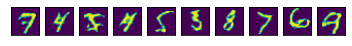

Epoch: 31
Epoch: [31] [  50/ 200] D_loss: 0.90903020, G_loss: 1.69235504
Epoch: [31] [ 100/ 200] D_loss: 1.01546931, G_loss: 1.16816700
Epoch: [31] [ 150/ 200] D_loss: 0.87881947, G_loss: 1.68590832
Epoch: [31] [ 200/ 200] D_loss: 0.83807170, G_loss: 1.56171227
Epoch: 32
Epoch: [32] [  50/ 200] D_loss: 0.92323804, G_loss: 1.75558615
Epoch: [32] [ 100/ 200] D_loss: 0.86189365, G_loss: 1.47329211
Epoch: [32] [ 150/ 200] D_loss: 0.91861975, G_loss: 1.15144777
Epoch: [32] [ 200/ 200] D_loss: 1.09764051, G_loss: 1.43753970
Epoch: 33
Epoch: [33] [  50/ 200] D_loss: 0.88038319, G_loss: 1.28688061
Epoch: [33] [ 100/ 200] D_loss: 0.92071617, G_loss: 1.28726506
Epoch: [33] [ 150/ 200] D_loss: 0.85141301, G_loss: 1.32313859
Epoch: [33] [ 200/ 200] D_loss: 0.86714053, G_loss: 1.51586306
Epoch: 34
Epoch: [34] [  50/ 200] D_loss: 0.97906375, G_loss: 1.49802125
Epoch: [34] [ 100/ 200] D_loss: 0.99711645, G_loss: 1.80989504
Epoch: [34] [ 150/ 200] D_loss: 0.88681197, G_loss: 1.51957357
Epoch: [34] [ 2

<Figure size 72x720 with 0 Axes>

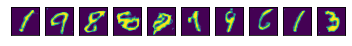

Epoch: 41
Epoch: [41] [  50/ 200] D_loss: 0.96549153, G_loss: 1.17419744
Epoch: [41] [ 100/ 200] D_loss: 0.91885078, G_loss: 1.73760581
Epoch: [41] [ 150/ 200] D_loss: 0.85352308, G_loss: 1.69146121
Epoch: [41] [ 200/ 200] D_loss: 0.79231775, G_loss: 1.57787728
Epoch: 42
Epoch: [42] [  50/ 200] D_loss: 0.80695254, G_loss: 1.77613652
Epoch: [42] [ 100/ 200] D_loss: 0.85653895, G_loss: 1.71730578
Epoch: [42] [ 150/ 200] D_loss: 0.83741552, G_loss: 1.45929563
Epoch: [42] [ 200/ 200] D_loss: 0.80892837, G_loss: 1.63956046
Epoch: 43
Epoch: [43] [  50/ 200] D_loss: 0.80664814, G_loss: 1.94476891
Epoch: [43] [ 100/ 200] D_loss: 0.80129570, G_loss: 1.47779500
Epoch: [43] [ 150/ 200] D_loss: 0.82210243, G_loss: 1.94620526
Epoch: [43] [ 200/ 200] D_loss: 0.98771435, G_loss: 1.75558209
Epoch: 44
Epoch: [44] [  50/ 200] D_loss: 0.83597952, G_loss: 1.46045172
Epoch: [44] [ 100/ 200] D_loss: 0.87142384, G_loss: 1.50067616
Epoch: [44] [ 150/ 200] D_loss: 0.85607457, G_loss: 2.00847149
Epoch: [44] [ 2

<Figure size 72x720 with 0 Axes>

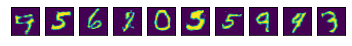

Epoch: 51
Epoch: [51] [  50/ 200] D_loss: 0.84709299, G_loss: 1.54497707
Epoch: [51] [ 100/ 200] D_loss: 0.78153259, G_loss: 2.11430955
Epoch: [51] [ 150/ 200] D_loss: 0.80381811, G_loss: 1.76598966
Epoch: [51] [ 200/ 200] D_loss: 0.81285965, G_loss: 1.36804152
Epoch: 52
Epoch: [52] [  50/ 200] D_loss: 0.87636817, G_loss: 1.66729999
Epoch: [52] [ 100/ 200] D_loss: 0.77240729, G_loss: 2.16709185
Epoch: [52] [ 150/ 200] D_loss: 0.78764987, G_loss: 1.80243409
Epoch: [52] [ 200/ 200] D_loss: 0.78732431, G_loss: 1.60210061
Epoch: 53
Epoch: [53] [  50/ 200] D_loss: 0.77732420, G_loss: 1.70432222
Epoch: [53] [ 100/ 200] D_loss: 0.83349752, G_loss: 1.79681826
Epoch: [53] [ 150/ 200] D_loss: 0.77080870, G_loss: 1.73923421
Epoch: [53] [ 200/ 200] D_loss: 0.78890622, G_loss: 1.57656252
Epoch: 54
Epoch: [54] [  50/ 200] D_loss: 0.84822798, G_loss: 1.51027393
Epoch: [54] [ 100/ 200] D_loss: 0.84428889, G_loss: 2.11639833
Epoch: [54] [ 150/ 200] D_loss: 0.88790727, G_loss: 2.58419132
Epoch: [54] [ 2

<Figure size 72x720 with 0 Axes>

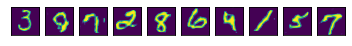

Epoch: 61
Epoch: [61] [  50/ 200] D_loss: 0.77870488, G_loss: 1.62734747
Epoch: [61] [ 100/ 200] D_loss: 0.73825622, G_loss: 1.85433662
Epoch: [61] [ 150/ 200] D_loss: 0.86489916, G_loss: 1.77501678
Epoch: [61] [ 200/ 200] D_loss: 0.89267975, G_loss: 1.73253787
Epoch: 62
Epoch: [62] [  50/ 200] D_loss: 0.88789707, G_loss: 1.77175176
Epoch: [62] [ 100/ 200] D_loss: 0.76104188, G_loss: 1.64738846
Epoch: [62] [ 150/ 200] D_loss: 0.72633928, G_loss: 2.30549026
Epoch: [62] [ 200/ 200] D_loss: 0.73377723, G_loss: 2.09459281
Epoch: 63
Epoch: [63] [  50/ 200] D_loss: 0.80974364, G_loss: 1.25589442
Epoch: [63] [ 100/ 200] D_loss: 0.73992801, G_loss: 1.69170356
Epoch: [63] [ 150/ 200] D_loss: 0.80653334, G_loss: 2.08013892
Epoch: [63] [ 200/ 200] D_loss: 0.74185050, G_loss: 1.80012047
Epoch: 64
Epoch: [64] [  50/ 200] D_loss: 0.73222995, G_loss: 2.02060127
Epoch: [64] [ 100/ 200] D_loss: 0.80411172, G_loss: 2.09424496
Epoch: [64] [ 150/ 200] D_loss: 0.72984517, G_loss: 1.80427206
Epoch: [64] [ 2

<Figure size 72x720 with 0 Axes>

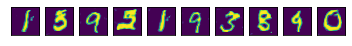

Epoch: 71
Epoch: [71] [  50/ 200] D_loss: 0.72102594, G_loss: 1.86341703
Epoch: [71] [ 100/ 200] D_loss: 0.73191607, G_loss: 1.74987292
Epoch: [71] [ 150/ 200] D_loss: 0.73671198, G_loss: 1.96952665
Epoch: [71] [ 200/ 200] D_loss: 0.87753093, G_loss: 2.93446016
Epoch: 72
Epoch: [72] [  50/ 200] D_loss: 0.79854178, G_loss: 1.68070984
Epoch: [72] [ 100/ 200] D_loss: 0.76336694, G_loss: 1.88082743
Epoch: [72] [ 150/ 200] D_loss: 0.73767650, G_loss: 1.92468631
Epoch: [72] [ 200/ 200] D_loss: 0.74451041, G_loss: 2.05392957
Epoch: 73
Epoch: [73] [  50/ 200] D_loss: 0.71189368, G_loss: 2.07072353
Epoch: [73] [ 100/ 200] D_loss: 0.71926671, G_loss: 1.89826953
Epoch: [73] [ 150/ 200] D_loss: 0.79162562, G_loss: 2.43479204
Epoch: [73] [ 200/ 200] D_loss: 0.73909009, G_loss: 1.85046029
Epoch: 74
Epoch: [74] [  50/ 200] D_loss: 0.84927166, G_loss: 1.38180184
Epoch: [74] [ 100/ 200] D_loss: 0.72603369, G_loss: 2.03010511
Epoch: [74] [ 150/ 200] D_loss: 0.76673025, G_loss: 2.32080364
Epoch: [74] [ 2

<Figure size 72x720 with 0 Axes>

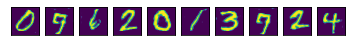

Epoch: 81
Epoch: [81] [  50/ 200] D_loss: 0.74690104, G_loss: 1.94677532
Epoch: [81] [ 100/ 200] D_loss: 0.71782649, G_loss: 2.07073903
Epoch: [81] [ 150/ 200] D_loss: 0.71881437, G_loss: 1.63340056
Epoch: [81] [ 200/ 200] D_loss: 0.73471594, G_loss: 1.75455117
Epoch: 82
Epoch: [82] [  50/ 200] D_loss: 0.71549654, G_loss: 2.05027556
Epoch: [82] [ 100/ 200] D_loss: 0.73124427, G_loss: 1.69549155
Epoch: [82] [ 150/ 200] D_loss: 0.70888555, G_loss: 2.20890594
Epoch: [82] [ 200/ 200] D_loss: 0.78998941, G_loss: 1.85330677
Epoch: 83
Epoch: [83] [  50/ 200] D_loss: 0.71695441, G_loss: 2.27923131
Epoch: [83] [ 100/ 200] D_loss: 0.96455997, G_loss: 1.93638432
Epoch: [83] [ 150/ 200] D_loss: 0.74946213, G_loss: 1.83036113
Epoch: [83] [ 200/ 200] D_loss: 0.71664333, G_loss: 2.04701257
Epoch: 84
Epoch: [84] [  50/ 200] D_loss: 0.70393997, G_loss: 2.16971517
Epoch: [84] [ 100/ 200] D_loss: 0.73370302, G_loss: 2.11377525
Epoch: [84] [ 150/ 200] D_loss: 0.77891576, G_loss: 1.92815125
Epoch: [84] [ 2

<Figure size 72x720 with 0 Axes>

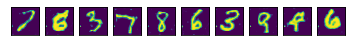

Epoch: 91
Epoch: [91] [  50/ 200] D_loss: 0.74206817, G_loss: 2.45269203
Epoch: [91] [ 100/ 200] D_loss: 0.70293522, G_loss: 2.21986318
Epoch: [91] [ 150/ 200] D_loss: 0.74101675, G_loss: 1.72516406
Epoch: [91] [ 200/ 200] D_loss: 0.71676815, G_loss: 2.33732748
Epoch: 92
Epoch: [92] [  50/ 200] D_loss: 0.72939485, G_loss: 2.28130126
Epoch: [92] [ 100/ 200] D_loss: 0.71551836, G_loss: 1.84051931
Epoch: [92] [ 150/ 200] D_loss: 0.70169955, G_loss: 1.72155356
Epoch: [92] [ 200/ 200] D_loss: 0.77995437, G_loss: 1.59137273
Epoch: 93
Epoch: [93] [  50/ 200] D_loss: 0.72918022, G_loss: 2.27033377
Epoch: [93] [ 100/ 200] D_loss: 0.72323984, G_loss: 2.24848223
Epoch: [93] [ 150/ 200] D_loss: 0.70057237, G_loss: 2.09071350
Epoch: [93] [ 200/ 200] D_loss: 0.74919796, G_loss: 2.36408615
Epoch: 94
Epoch: [94] [  50/ 200] D_loss: 0.79071093, G_loss: 1.90993023
Epoch: [94] [ 100/ 200] D_loss: 0.71691394, G_loss: 1.83723819
Epoch: [94] [ 150/ 200] D_loss: 0.71855545, G_loss: 1.75552762
Epoch: [94] [ 2

<Figure size 72x720 with 0 Axes>

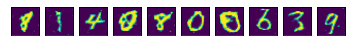

Training finished!


In [11]:
params = {'beta1': 0.5, 'beta2': 0.999,'lr_g':0.0002,'lr_d':0.0002,'max_epochs':100}
params['z_dim'] = 2
params['base_size'] = 64

gan = GAN(params)
gan.train()